In [1]:
import numpy
from matplotlib import pyplot as plt
%matplotlib inline

Linear regression
-----------------

Data from Example 6.1 of Seborg, Edgar, Melichamp and Doyle (3rd edition)

In [2]:
import pandas

In [3]:
df = pandas.read_excel('example_6_1.xlsx')

In [4]:
x = df['Fuel Flow Rate']
y = df['Power Generated']

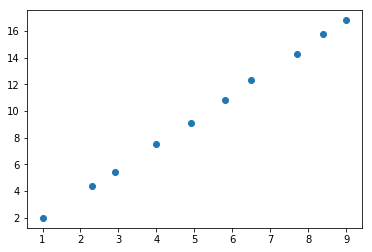

In [5]:
plt.scatter(x, y)

First, let's apply the pseudoinverse method directly (note **you should never do this for production code**, as calculating inverses is computationally expensive)

If $\beta=\begin{bmatrix}a\\b\end{bmatrix}$, $Y = \begin{bmatrix}y_1\\y_2\\\vdots \end{bmatrix}$, $X = \begin{bmatrix}x_1 & 1 \\x_2 & 1\\\vdots & \vdots \end{bmatrix}$

In [6]:
Y = numpy.asmatrix(y).T
X = numpy.bmat([numpy.c_[x], numpy.ones_like(Y)])

then the solution minimising the sum of the squares of the residual ( $Y - X\beta$ ) is 

$$ \hat{\beta} = (X^TX)^{-1}X^T Y $$

In [7]:
#Excel: =MMULT((MINVERSE(MMULT(TRANSPOSE(_X); _X))); MMULT(TRANSPOSE(_X); _Y))
betahat = (X.T*X).I*X.T*Y
betahat

matrix([[ 1.85932397],
        [ 0.07854918]])

*Note:* The code above is as close as possible to the equation above, as I have made `X` and `Y` matrices. Normal `numpy.array`s don't have an `.I` property and don't multiply matrix-fasion but rather element-wise. Here is how we would have to write the code if we used arrays:

In [8]:
Y = numpy.asarray(Y)
X = numpy.asarray(X)

In [9]:
numpy.linalg.inv(X.T @ X) @ X.T @ Y

array([[ 1.85932397],
       [ 0.07854918]])

Since calculating the inverse is not a numerically well behaved operation, so you should rather use a dedicated routine if you are solving this kind of problem:

In [10]:
beta, residuals, rank, s = numpy.linalg.lstsq(X, Y)
beta

array([[ 1.85932397],
       [ 0.07854918]])

However, polynomial fits are such a common operation that there are nicer routines to do this fit. There are a whole range of functions in numpy which start with poly. Press tab to see them.

In [11]:
numpy.poly

<function numpy.lib.polynomial.poly>

In [12]:
poly = numpy.polyfit(x, y, 1)
poly

array([ 1.85932397,  0.07854918])

Notice that we could just pass the data directly, and the routine handled building the various matrices and the fitting itself.

It is useful to plot the regression with the data points, but we should sample on a finer grid.

In [13]:
smoothx = numpy.linspace(min(x), max(x))

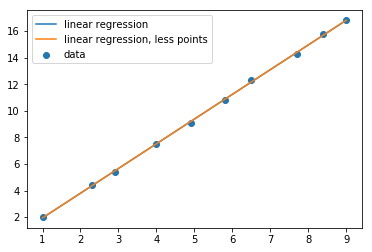

In [14]:
def regplot(poly):
    smoothy = numpy.polyval(poly, smoothx)
    plt.scatter(x, y, label='data')
    plt.plot(smoothx, smoothy, label='linear regression')
    plt.plot(x, numpy.polyval(poly, x), label='linear regression, less points')
    plt.legend(loc='best')
regplot(poly)

There's obviously no difference between the two for a linear fit, but what about a more squigly one?

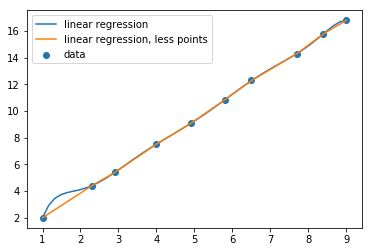

In [15]:
poly9 = numpy.polyfit(x, y, 8)
regplot(poly9)

If we had just plotted the connecting lines, we would have missed the bit sticking up on the left!

Nonlinear regression
-------------------

We can apply the same principles to fit nonlinear functions as well. The `scipy.optimize.curve_fit` function can be used to fit an aribitrary function to data

In [16]:
import scipy.optimize

Let's start by reproducing the results from the linear fit

In [17]:
def f(x, a, b):
    """fitting function"""
    return a*x + b

In [18]:
beta, _ = scipy.optimize.curve_fit(f, x, y, [1, 0])
beta

array([ 1.85932396,  0.07854919])

In [19]:
def f2(x, a, b, c):
    """ A nonlinear fitting function"""
    return numpy.sin(a*x) + b*x + c

In [20]:
beta, _ = scipy.optimize.curve_fit(f2, x, y, [1, 1, 1])

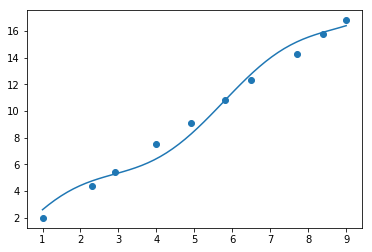

In [21]:
plt.scatter(x, y)
plt.plot(smoothx, f2(smoothx, *beta))